In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
from keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### Reading the data, normalizing and flattening it

##### Reading tand Normalizing

In [2]:

train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 11385 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


##### Flattening

Preparing training tensors

In [3]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in train:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
train_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing validation tensors

In [4]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in val:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
val_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing testing tensors

In [5]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in test:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
test_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

#### PCA

Reduce the dimensions to 32, 64, 128 and 256 dimensions through PCA

In [6]:
mean = tf.reduce_mean(image_vectors, axis=0)

In [7]:
train_vectors[0] -= mean
val_vectors[0] -= mean
test_vectors[0] -= mean

In [8]:
num_components = [32,64,128,256]

def get_reduced_representation(dim, vec):
    # Calculate the covariance matrix
    cov = tf.matmul(vec[0], vec[0], transpose_a=True)# / tf.cast(tf.shape(vec[0])[0], tf.float32)

    # Perform eigenvalue decomposition on the covariance matrix
    eigenvalues, eigenvectors = tf.linalg.eigh(cov)

    # Sort the eigenvectors by eigenvalues in descending order
    sorted_idx = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors = tf.gather(eigenvectors, sorted_idx, axis=1)

    # Keep only the top k eigenvectors
    top_k_eigenvectors = tf.slice(eigenvectors, [0, 0], [-1, dim])

    # Project the data onto the new basis
    reduced_rep = tf.matmul(vec[0], top_k_eigenvectors)
    return reduced_rep

In [9]:
t = get_reduced_representation(32, train_vectors)
train_vectors[1].numpy().shape

(11385,)

#### Building the model

In [10]:
model_arch = [
    [96, 64, 32],
    [64, 96, 128],
    [128, 96, 64],
    [256, 128, 96]
]

In [17]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training models with different architectures and optimizers')
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        # define model
        model = Sequential([
            layers.Dense(reduced_dimension, activation="relu", input_shape=(reduced_dimension,)),
            # keras.Input(input_shape=(reduced_dimension,)),
            layers.Dense(layer_dims[0], activation="sigmoid", name="layer1", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[1], activation="sigmoid", name="layer2", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(layer_dims[2], activation="sigmoid", name="layer3", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            # layers.Dense(layer_dims[3], activation="sigmoid", name="layer4", 
            #              kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
            layers.Dense(5, activation="softmax", name="output", 
                         kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        ])
        
        # compile model
        adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # callbacks
        my_callbacks = [
            EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
            TensorBoard(log_dir=f'./logdir/Q1/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}/')
        ]
        model_fit = model.fit(reduced_rep_train.numpy(),train_vectors[1].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                              validation_split=0.0, validation_data=(reduced_rep_val.numpy(), val_vectors[1].numpy()), shuffle=True, validation_batch_size=None)
        
        model_history[f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}'] = model_fit.history['accuracy']
        
        hist_metric = 'accuracy'
        print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
        model.save(f'models/Q1/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')



Training models with different architectures and optimizers
32-96-64-32...
epochs: 180, acc: 0.6395257115364075

32-64-96-128...
epochs: 176, acc: 0.9407992959022522

32-128-96-64...
epochs: 260, acc: 0.9758453965187073

32-256-128-96...
epochs: 241, acc: 0.9826086759567261

64-96-64-32...
epochs: 225, acc: 0.7262187004089355

64-64-96-128...
epochs: 168, acc: 0.9702239632606506

64-128-96-64...
epochs: 136, acc: 0.9580149054527283

64-256-128-96...
epochs: 173, acc: 0.9886692762374878

128-96-64-32...
epochs: 183, acc: 0.79991215467453

128-64-96-128...
epochs: 142, acc: 0.9790074825286865

128-128-96-64...
epochs: 112, acc: 0.8648221492767334

128-256-128-96...
epochs: 92, acc: 0.9644268751144409

256-96-64-32...
epochs: 283, acc: 0.9974527955055237

256-64-96-128...
epochs: 141, acc: 0.9887571334838867

256-128-96-64...
epochs: 112, acc: 0.9880544543266296

256-256-128-96...
epochs: 88, acc: 0.9813790321350098



In [18]:
for reduced_dimension in [32,64,128,256]:
    reduced_rep_train = get_reduced_representation(reduced_dimension, train_vectors)
    reduced_rep_val = get_reduced_representation(reduced_dimension, val_vectors)
    reduced_rep_test = get_reduced_representation(reduced_dimension, test_vectors)
    for layer_dims in model_arch:
        print(f'{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}...')
        temp_model = tf.keras.models.load_model(
            f'models/Q1/{reduced_dimension}-{layer_dims[0]}-{layer_dims[1]}-{layer_dims[2]}.tf')
        l, acc = temp_model.evaluate(reduced_rep_train.numpy(), train_vectors[1].numpy())
        l, acc = temp_model.evaluate(reduced_rep_val.numpy(), val_vectors[1].numpy())
        l, acc = temp_model.evaluate(reduced_rep_test.numpy(), test_vectors[1].numpy())
        print('\n\n')

32-96-64-32...
119/119 [==============================] - 0s 752us/step - loss: 0.9414 - accuracy: 0.5863



32-64-96-128...
119/119 [==============================] - 0s 757us/step - loss: 0.5522 - accuracy: 0.8121



32-128-96-64...
119/119 [==============================] - 0s 786us/step - loss: 0.4447 - accuracy: 0.8556



32-256-128-96...
119/119 [==============================] - 0s 938us/step - loss: 0.4686 - accuracy: 0.8493



64-96-64-32...
119/119 [==============================] - 0s 762us/step - loss: 0.9730 - accuracy: 0.6519



64-64-96-128...
119/119 [==============================] - 0s 744us/step - loss: 0.5316 - accuracy: 0.8121



64-128-96-64...
119/119 [==============================] - 0s 778us/step - loss: 0.6828 - accuracy: 0.7866



64-256-128-96...
119/119 [==============================] - 0s 854us/step - loss: 0.5737 - accuracy: 0.8253



128-96-64-32...
119/119 [==============================] - 0s 771us/step - loss: 0.8151 - accuracy: 0.7170



128-64-96-

119/119 [==============================] - 0s 668us/step
confusion matrix (test):


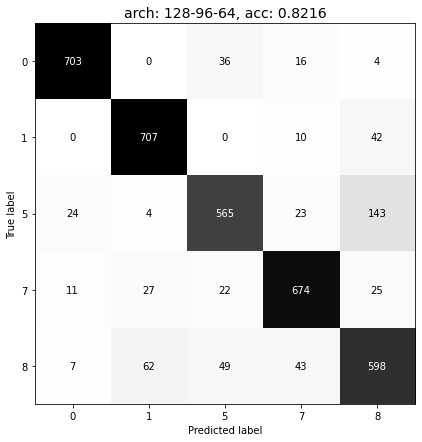

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

best_arch = '128-96-64'
best_model = tf.keras.models.load_model(
            f'models/Q1/{32}-{best_arch}.tf')

test_pred = best_model.predict(get_reduced_representation(32, test_vectors))
pred_class_test = np.argmax(test_pred, axis=1)

test_score = accuracy_score(test_vectors[1].numpy(), pred_class_test)

print('confusion matrix (test):')
fig = plt.figure(figsize=(7, 7))
#fig.suptitle('Confusion Matrix (Test Set)', y=0.04, fontsize=15)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_vectors[1].numpy(), pred_class_test), display_labels=['0', '1', '5', '7', '8'])
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
ax.set_title(f'arch: {best_arch}, acc: {0.8216}', fontdict = {'fontsize':14}, )
plt.show()

In [19]:
train_vectors[1].numpy()

array([2, 0, 2, ..., 1, 4, 2])